In [1]:
import numpy as np
from scipy.stats import norm, t, chi2, bernoulli, multivariate_normal, f

import matplotlib.pyplot as plt
from matplotlib import cm, rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Confidence interval for difference of population means $\mu_x - \mu_y$ with independent samples and unknown variances $\sigma^2_x \not = \sigma^2_y$

$$
\left( \mu_x - \mu_y \right)_{1 - \alpha} \in \overline{X} - \overline{Y} \pm t_{k; \; \alpha / 2} \cdot \sqrt{\dfrac{s^2_x}{n_x} + \dfrac{s^2_y}{n_y}}
$$
where
$$
k = \left \lfloor \dfrac{\left( \dfrac{s^2_x}{n_x} + \dfrac{s^2_y}{n_y} \right)^2}{\dfrac{\left( \dfrac{s^2_x}{n_x} \right)^2}{n_x - 1} + \dfrac{\left( \dfrac{s^2_y}{n_y} \right)^2}{n_y - 1}} \right \rceil
$$

In [2]:
def sample_mean(sample):
    
    return np.mean(sample)

def sample_std(sample):
    
    n = len(sample)
    
    return np.sqrt((np.sum(sample**2) - n * sample_mean(sample)**2) / (n - 1))

def critical_value_t(df, alpha):
    
    return t.isf(alpha / 2, df)

def df_for_mean_diff(s_x, s_y, n_x, n_y):
    
    term_x = s_x**2 / n_x
    term_y = s_y**2 / n_y
    
    return np.round((term_x + term_y)**2 / (term_x**2 / (n_x - 1) + term_y**2 / (n_y - 1)))

def CI_mean_difference__indep_samples__var_unknown_unequal(sample_x, sample_y, alpha):
    
    x_bar  = sample_mean(sample_x)
    s_x    = sample_std(sample_x)
    n_x    = len(sample_x)
    
    y_bar  = sample_mean(sample_y)
    s_y    = sample_std(sample_y)
    n_y    = len(sample_y)
    
    xy_bar = x_bar - y_bar
    se_xy  = np.sqrt(s_x**2 / n_x + s_y**2 / n_y)
    
    k      = df_for_mean_diff(s_x, s_y, n_x, n_y)
    t_crit = critical_value_t(k, alpha)
    
    lower_bound = xy_bar - t_crit * se_xy
    upper_bound = xy_bar + t_crit * se_xy
    
    return (lower_bound, upper_bound)

In [3]:
ALPHA = 0.05

MU_X = 15
MU_Y = 10

SIGMA_X = 2
SIGMA_Y = 6

SIZE_X = 12
SIZE_Y = 7

SAMPLE_X = norm.rvs(MU_X, SIGMA_X, SIZE_X)
SAMPLE_Y = norm.rvs(MU_Y, SIGMA_Y, SIZE_Y)

print(CI_mean_difference__indep_samples__var_unknown_unequal(SAMPLE_X, SAMPLE_Y, ALPHA))

(-2.3101882949008337, 7.959541872834262)


# VI. Ratio of variances

## Confidence interval for ratio of population variances $\dfrac{\sigma^2_y}{\sigma^2_x}$ with known means $\mu_x, \mu_y$

$$
\left( \dfrac{\sigma^2_y}{\sigma^2_x} \right)_{1 - \alpha} \in \left( \dfrac{1}{F_{n_y; \; n_x; \; \alpha/2}} \cdot \dfrac{\varsigma^2_y}{\varsigma^2_x} ; \; F_{n_x; \; n_y; \; \alpha/2} \cdot \dfrac{\varsigma^2_y}{\varsigma^2_x} \right)
$$
where
$$
\varsigma^2_x = \dfrac{1}{n_x} \sum\limits_{i=1}^{n_x} \left( X_i - \mu_x \right)^2 \qquad \text{and} \qquad \varsigma^2_y = \dfrac{1}{n_y} \sum\limits_{i=1}^{n_y} \left( Y_i - \mu_y \right)^2
$$

In [4]:
def critical_value_F(df_num, df_den, alpha):
    
    return f.isf(alpha / 2, df_num, df_den)

def CI_variances_ratio__means_known(sample_x, sample_y, mu_x, mu_y, alpha):
    
    n_x         = len(sample_x)
    varsigma2_x = np.sum((sample_x - mu_x)**2) / n_x
    
    n_y         = len(sample_y)
    varsigma2_y = np.sum((sample_y - mu_y)**2) / n_y
    
    var_ratio   = varsigma2_y / varsigma2_x
    
    F_crit_l    = 1 / critical_value_F(n_y, n_x, alpha)
    F_crit_u    = critical_value_F(n_x, n_y, alpha)
    
    lower_bound = F_crit_l * var_ratio
    upper_bound = F_crit_u * var_ratio
    
    return (lower_bound, upper_bound)

In [5]:
print(CI_variances_ratio__means_known(SAMPLE_X, SAMPLE_Y, MU_X, MU_Y, ALPHA))

(1.5719494590145717, 26.451795904477052)


In [6]:
SIZES = [10, 100000]

for size in SIZES:

    sample_x = norm.rvs(MU_X, SIGMA_X, size)
    sample_y = norm.rvs(MU_Y, SIGMA_Y, size)

    print('n =', size, ':\t', CI_variances_ratio__means_known(sample_x, sample_y, MU_X, MU_Y, ALPHA))

n = 10 :	 (1.3933444470905996, 19.248415056997697)
n = 100000 :	 (8.8763221042313, 9.099133929334215)


## Confidence interval for ratio of population variances $\dfrac{\sigma^2_y}{\sigma^2_x}$ with unknown means

$$
\left( \dfrac{\sigma^2_y}{\sigma^2_x} \right)_{1 - \alpha} \in \left( \dfrac{1}{F_{n_y-1; \; n_x-1; \; \alpha/2}} \cdot \dfrac{s^2_y}{s^2_x} ; \; F_{n_x-1; \; n_y-1; \; \alpha/2} \cdot \dfrac{s^2_y}{s^2_x} \right)
$$

In [7]:
def CI_variances_ratio__means_unknown(sample_x, sample_y, alpha):
    
    n_x         = len(sample_x)
    sigma2_x    = sample_std(sample_x)**2
    
    n_y         = len(sample_y)
    sigma2_y    = sample_std(sample_y)**2
    
    var_ratio   = sigma2_y / sigma2_x
    
    F_crit_l    = 1 / critical_value_F(n_y - 1, n_x - 1, alpha)
    F_crit_u    = critical_value_F(n_x - 1, n_y - 1, alpha)
    
    lower_bound = F_crit_l * var_ratio
    upper_bound = F_crit_u * var_ratio
    
    return (lower_bound, upper_bound)

In [8]:
print(CI_variances_ratio__means_unknown(SAMPLE_X, SAMPLE_Y, ALPHA))

(1.2801483754559544, 26.874661078564287)


# VII. Correlation coefficient

### Samples from bivariate normal distribution

Covariance matrix for $\mathbf{X} = \left( X_1, X_2 \right)^{\top}$:

$$
\begin{aligned}
\mathbf{\Sigma}_{\mathbf{X}} = \mathsf{E} \left[ \left( \mathbf{X} - \mathsf{E} (\mathbf{X}) \right) \left( \mathbf{X} - \mathsf{E} (\mathbf{X}) \right)^{\top} \right] &= \begin{pmatrix} \mathsf{E} \left[ \left( X_1 - \mathsf{E} (X_1) \right)^2 \right] & \mathsf{E} \left[ \left( X_1 - \mathsf{E} (X_1) \right) \left( X_2 - \mathsf{E} (X_2) \right) \right] \\ \mathsf{E} \left[ \left( X_2 - \mathsf{E} (X_2) \right) \left( X_1 - \mathsf{E} (X_1) \right) \right] & \mathsf{E} \left[ \left( X_2 - \mathsf{E} (X_2) \right)^2 \right] \end{pmatrix} = \\
 &= \begin{pmatrix} \mathsf{V} (X_1) & \mathsf{Cov} (X_1, X_2) \\ \mathsf{Cov} (X_2, X_1) & \mathsf{V} (X_2) \end{pmatrix}
\end{aligned}
$$

In [9]:
COV = np.array([[9, -6], [-6, 16]])

# rho = -6 / sqrt(9 * 16) = -0.5

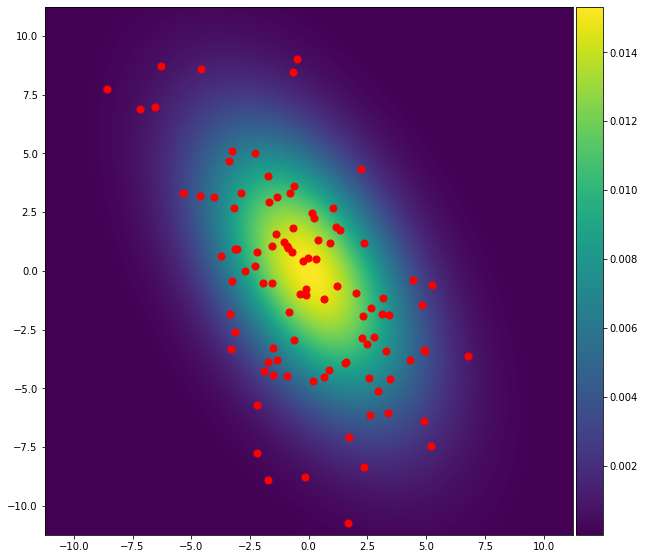

In [10]:
SIZE = 100
SAMPLE = multivariate_normal.rvs(cov=COV, size=SIZE)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

max_val = np.max(np.abs(SAMPLE)) + 0.5
x, y = np.mgrid[-max_val : max_val : .01,
                -max_val : max_val : .01]
pos = np.dstack((x, y))

im = ax.imshow(multivariate_normal(cov=COV).pdf(pos).T,
               interpolation='spline36',
               extent=[-max_val, max_val, -max_val, max_val],
               origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax.scatter(SAMPLE[:,0], SAMPLE[:,1], c='red', s=50)

plt.show()

In [11]:
SIZE = 10
SAMPLE = multivariate_normal.rvs(cov=COV, size=SIZE)

print(SAMPLE)

[[-6.9069977   6.63321391]
 [ 2.07370829 -1.16080151]
 [-9.10007801  5.78527637]
 [ 2.02828948 -1.90985587]
 [ 3.65574729  2.05388565]
 [ 1.31307427 -4.81393642]
 [-1.89604538 -2.65228985]
 [-1.93539945  1.40017099]
 [-1.81708263  1.03774309]
 [ 0.86411491 -1.13062205]]


## Confidence interval for correlation coefficient $\rho$

$$
\left( \rho \right)_{1 - \alpha} \in \left( \text{tanh} \left( \text{artanh} \left( \widehat{\rho} \right) - \dfrac{z_{\alpha / 2}}{\sqrt{n - 3}} \right), \text{tanh} \left( \text{artanh} \left( \widehat{\rho} \right) + \dfrac{z_{\alpha / 2}}{\sqrt{n - 3}} \right) \right)
$$

In [12]:
def sample_corr(sample):
    
    sample_x = sample[:,0]
    sample_y = sample[:,1]
    
    x_bias = sample_x - sample_mean(sample_x)
    y_bias = sample_y - sample_mean(sample_y)
    
    return np.sum(x_bias * y_bias) / np.sqrt(np.sum(x_bias**2) * np.sum(y_bias**2))

def fisher_transform(rho):
    
    return 0.5 * np.log((1 + rho) / (1 - rho))

def inverse_fisher_transform(z):
    
    return (np.exp(2*z) - 1) / (np.exp(2*z) + 1)

def critical_value_z(alpha):
    
    return norm.isf(alpha / 2)

def CI_correlation(sample, alpha):
    
    rho_hat = sample_corr(sample)
    n       = len(sample)
    z_crit  = critical_value_z(alpha)
    
    z_hat   = fisher_transform(rho_hat)
    
    lower_bound = inverse_fisher_transform(z_hat - z_crit / np.sqrt(n - 3))
    upper_bound = inverse_fisher_transform(z_hat + z_crit / np.sqrt(n - 3))
    
    return (lower_bound, upper_bound)

In [13]:
ALPHA = 0.1
SIZES = [10, 100000]

for size in SIZES:

    SAMPLE = multivariate_normal.rvs(cov=COV, size=size)

    print('n =', size, ':\t', CI_correlation(SAMPLE, ALPHA))

n = 10 :	 (-0.8096310830438713, 0.1168983665642743)
n = 100000 :	 (-0.5029156340383647, -0.4951031189086935)
